
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/086_PointNet_3D_PointCloud.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/86_PointNet_3D_PointCloud.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# ☁️ PointNet: Jak AI widzi chmury punktów?

Większość danych 3D to nie siatki (Mesh), ale **Chmury Punktów**.
To po prostu zbiór $N$ punktów $(x, y, z)$.

**Wyzwanie:**
Lista punktów to **Zbiór**, a nie Sekwencja.
Sieć musi zrozumieć kształt "Kuli" niezależnie od tego, czy zaczniemy czytanie punktów od bieguna północnego, czy południowego.

**Rozwiązanie PointNet:**
1.  **Shared MLP:** Przepuszczamy *każdy punkt osobno* przez tę samą małą sieć. (Każdy punkt dowiaduje się czegoś o sobie).
2.  **Global Max Pooling:** To klucz! Bierzemy **maksymalną wartość** z wszystkich punktów dla każdej cechy.
    *   Max(A, B, C) to to samo co Max(C, A, B). Kolejność znika!
3.  **Klasyfikator:** Spłaszczony wektor (Global Feature) wrzucamy do zwykłego MLP.

Zbudujemy sieć, która rozróżnia **Kulę** od **Sześcianu**.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_POINTS = 1024 # Ile punktów ma jeden obiekt?
BATCH_SIZE = 32

print(f"Urządzenie: {DEVICE}")

Urządzenie: cuda


## Generowanie Danych 3D

Stwórzmy prosty dataset.
1.  **Kula:** Punkty znormalizowane (odległość od środka = 1).
2.  **Sześcian:** Punkty losowe w pudełku (od -1 do 1).

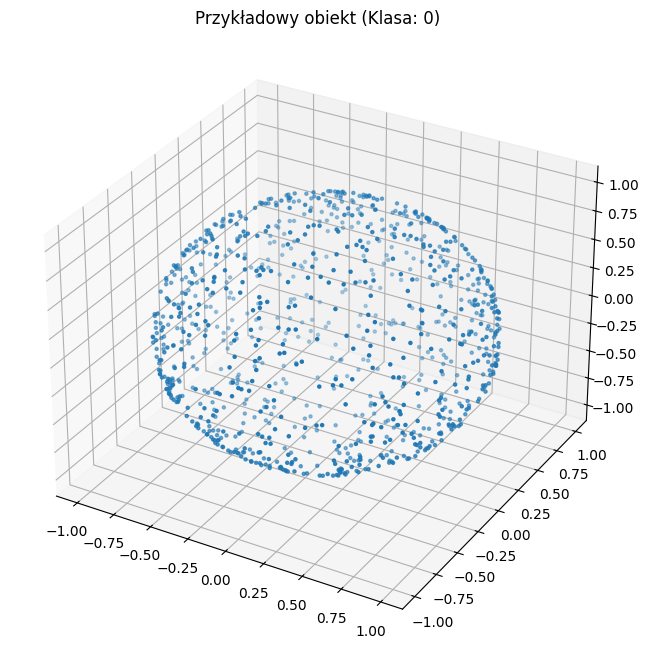

In [2]:
class ShapeDataset(Dataset):
    def __init__(self, size=1000):
        self.size = size
        self.data = []
        self.labels = []
        
        for _ in range(size):
            if np.random.rand() > 0.5:
                # KULA (Klasa 0)
                # Losujemy wektory Gaussa i normalizujemy je
                points = np.random.randn(NUM_POINTS, 3)
                points = points / np.linalg.norm(points, axis=1, keepdims=True)
                label = 0
            else:
                # SZEŚCIAN (Klasa 1)
                # Losujemy uniform -1 do 1
                points = np.random.uniform(-1, 1, (NUM_POINTS, 3))
                label = 1
                
            self.data.append(points)
            self.labels.append(label)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # PointNet oczekuje formatu: [Kanały, Liczba_Punktów] -> [3, 1024]
        # Dlatego robimy transpozycję (.T)
        return torch.tensor(self.data[idx].T, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Generujemy i oglądamy
dataset = ShapeDataset()
points, label = dataset[0] # Pobieramy jeden obiekt

# Wizualizacja 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
points_np = points.numpy()
ax.scatter(points_np[0], points_np[1], points_np[2], s=5)
ax.set_title(f"Przykładowy obiekt (Klasa: {label})")
plt.show()

## Architektura PointNet

Użyjemy sprytnego triku.
W PyTorch `nn.Conv1d` z `kernel_size=1` działa dokładnie jak **Shared MLP**.
Przesuwa się po każdym punkcie osobno i mnoży go przez te same wagi.

Struktura:
1.  `Input` (3, 1024)
2.  `Conv1d` (64 filtry) -> Każdy punkt zamienia się w wektor 64-elementowy.
3.  `Conv1d` (128 filtrów) -> Każdy punkt ma 128 cech.
4.  `Conv1d` (1024 filtry) -> Każdy punkt ma 1024 cechy.
5.  **Global Max Pooling** -> Z 1024 punktów zostaje **jeden wektor globalny**.
6.  `Linear` -> Klasyfikacja (Kula czy Sześcian?).

In [3]:
class PointNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # SHARED MLP (zrobione jako Conv1d z kernel=1)
        # To przetwarza każdy punkt niezależnie
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        
        # KLASYFIKATOR (Zwykły MLP na końcu)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2) # 2 klasy: Kula / Sześcian
        
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x shape: [Batch, 3, Num_Points]
        
        # 1. Local Features (Shared MLP)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        # x shape teraz: [Batch, 1024, Num_Points]
        
        # 2. GLOBAL MAX POOLING (Symetryzacja)
        # Bierzemy max po wymiarze punktów (dim=2)
        # To sprawia, że kolejność punktów przestaje mieć znaczenie!
        x = torch.max(x, 2, keepdim=False)[0]
        
        # x shape teraz: [Batch, 1024] (Global Feature Vector)
        
        # 3. Klasyfikacja
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # Logity
        
        return x

model = PointNet().to(DEVICE)
print("PointNet gotowy.")

PointNet gotowy.


In [4]:
# TRENING
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Start treningu (Klasyfikacja 3D)...")

for epoch in range(5): # 5 epok wystarczy na tak prosty problem
    total_loss = 0
    correct = 0
    total = 0
    
    for points, labels in loader:
        points, labels = points.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(points)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print(f"Epoka {epoch+1}, Loss: {total_loss/len(loader):.4f}, Acc: {100 * correct / total:.2f}%")

print("✅ Model nauczył się widzieć w 3D.")

Start treningu (Klasyfikacja 3D)...
Epoka 1, Loss: 0.2629, Acc: 88.10%
Epoka 2, Loss: 0.0001, Acc: 100.00%
Epoka 3, Loss: 0.0000, Acc: 100.00%
Epoka 4, Loss: 0.0000, Acc: 100.00%
Epoka 5, Loss: 0.0000, Acc: 100.00%
✅ Model nauczył się widzieć w 3D.


## Test Odporności na Permutacje

Sprawdźmy, czy model naprawdę jest odporny na kolejność punktów.
1.  Weźmiemy obiekt (np. Sześcian).
2.  Przepuścimy go przez sieć -> Wynik A.
3.  **Wymieszamy losowo kolejność punktów** (Shuffle).
4.  Przepuścimy przez sieć -> Wynik B.

Jeśli PointNet działa poprawnie, wyniki muszą być **identyczne**.

In [5]:
model.eval()

# Bierzemy jeden obiekt
points, label = dataset[5] # Jakiś losowy obiekt
points = points.to(DEVICE).unsqueeze(0) # Dodajemy batch [1, 3, 1024]

# 1. Oryginał
out_original = model(points)
prob_original = F.softmax(out_original, dim=1)[0]

# 2. Wymieszany (Permutacja)
# Mieszamy indeksy od 0 do 1023
idx = torch.randperm(points.shape[2])
points_shuffled = points[:, :, idx]

out_shuffled = model(points_shuffled)
prob_shuffled = F.softmax(out_shuffled, dim=1)[0]

print(f"Prawdziwa klasa: {label}")
print("-" * 30)
print(f"Oryginał:   Kula={prob_original[0]:.4f}, Sześcian={prob_original[1]:.4f}")
print(f"Wymieszany: Kula={prob_shuffled[0]:.4f}, Sześcian={prob_shuffled[1]:.4f}")

diff = torch.sum(torch.abs(out_original - out_shuffled)).item()
print("-" * 30)
print(f"Różnica w logitach: {diff:.10f}")

if diff < 1e-5:
    print("✅ IDEAŁ. Kolejność punktów nie ma znaczenia.")
else:
    print("❌ Coś jest nie tak. Wyniki są różne.")

Prawdziwa klasa: 1
------------------------------
Oryginał:   Kula=0.0000, Sześcian=1.0000
Wymieszany: Kula=0.0000, Sześcian=1.0000
------------------------------
Różnica w logitach: 0.0000000000
✅ IDEAŁ. Kolejność punktów nie ma znaczenia.


## 🧠 Podsumowanie: Global Feature

Dzięki operacji `torch.max()`, sieć wydobyła **Globalny Wektor Cech**.
Nieważne, w jakiej kolejności wchodziły punkty. Ważne, że w chmurze punktów:
*   Znalazł się punkt bardzo daleko od środka (w rogu sześcianu).
*   Znalazł się punkt płaski.

Sieć nauczyła się "obrysu" obiektu.
To fundamentalny algorytm dla **Lidarów** w samochodach autonomicznych (rozróżnianie pieszego od słupka).